## Concrete Strength Prediction using Linear Regression

This notebook analyzes concrete strength data and builds a linear regression model to predict concrete strength based on various components

## 1. Import Required Libraries

Import pandas, numpy, matplotlib, seaborn, and sklearn libraries for data manipulation, visualisation and machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

# set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print("Libraries imported successfully")

Libraries imported successfully


## 2. Load the Dataset

Use pandas to load the training and test datasets from CSV files.

In [7]:
# Load the datasets
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')
sample_submission = pd.read_csv('datasets/sample_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

# Display first few rows of training data
print("\nFirst 5 rows of training data:")
train_df.head()

Training data shape: (5407, 10)
Test data shape: (3605, 9)
Sample submission shape: (3605, 2)

First 5 rows of training data:


,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


## 3. Data Overview and Basic Information

Display basic information about the dataset including shape, data types, and missing values using pandas methods.

In [8]:
# Basic information about the dataset
print("Dataset Info:")
print(train_df.info())

print("\nDataset Description:")
print(train_df.describe())

print("\nMissing values in training data:")
print(train_df.isnull().sum())

print("\nMissing values in test data:")
print(test_df.isnull().sum())

print("\nColumn names:")
print(train_df.columns.tolist())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407 entries, 0 to 5406
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         5407 non-null   int64  
 1   CementComponent            5407 non-null   float64
 2   BlastFurnaceSlag           5407 non-null   float64
 3   FlyAshComponent            5407 non-null   float64
 4   WaterComponent             5407 non-null   float64
 5   SuperplasticizerComponent  5407 non-null   float64
 6   CoarseAggregateComponent   5407 non-null   float64
 7   FineAggregateComponent     5407 non-null   float64
 8   AgeInDays                  5407 non-null   int64  
 9   Strength                   5407 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 422.6 KB
None

Dataset Description:
                id  CementComponent  BlastFurnaceSlag  FlyAshComponent  \
count  5407.000000      5407.000000       5407.000000 

## 4. Exploratory Data Analysis (EDA)

Create visualizations and statistical summaries to understand data distributions, correlations, and patterns using matplotlib and seaborn.

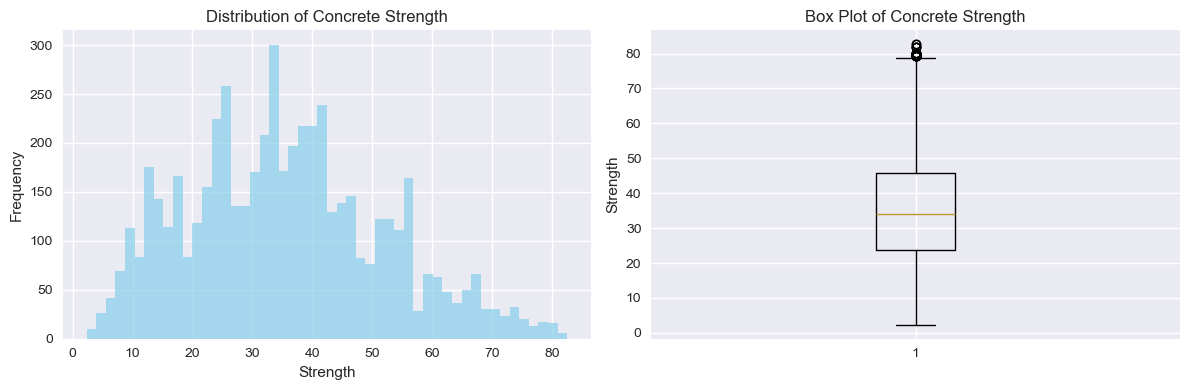

Strength statistics:
Mean: 35.45
Median: 33.95
Std: 16.40
Min: 2.33
Max: 82.60


In [9]:
# Target variable distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_df['Strength'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Concrete Strength')
plt.xlabel('Strength')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(train_df['Strength'])
plt.title('Box Plot of Concrete Strength')
plt.ylabel('Strength')

plt.tight_layout()
plt.show()

print(f"Strength statistics:")
print(f"Mean: {train_df['Strength'].mean():.2f}")
print(f"Median: {train_df['Strength'].median():.2f}")
print(f"Std: {train_df['Strength'].std():.2f}")
print(f"Min: {train_df['Strength'].min():.2f}")
print(f"Max: {train_df['Strength'].max():.2f}")

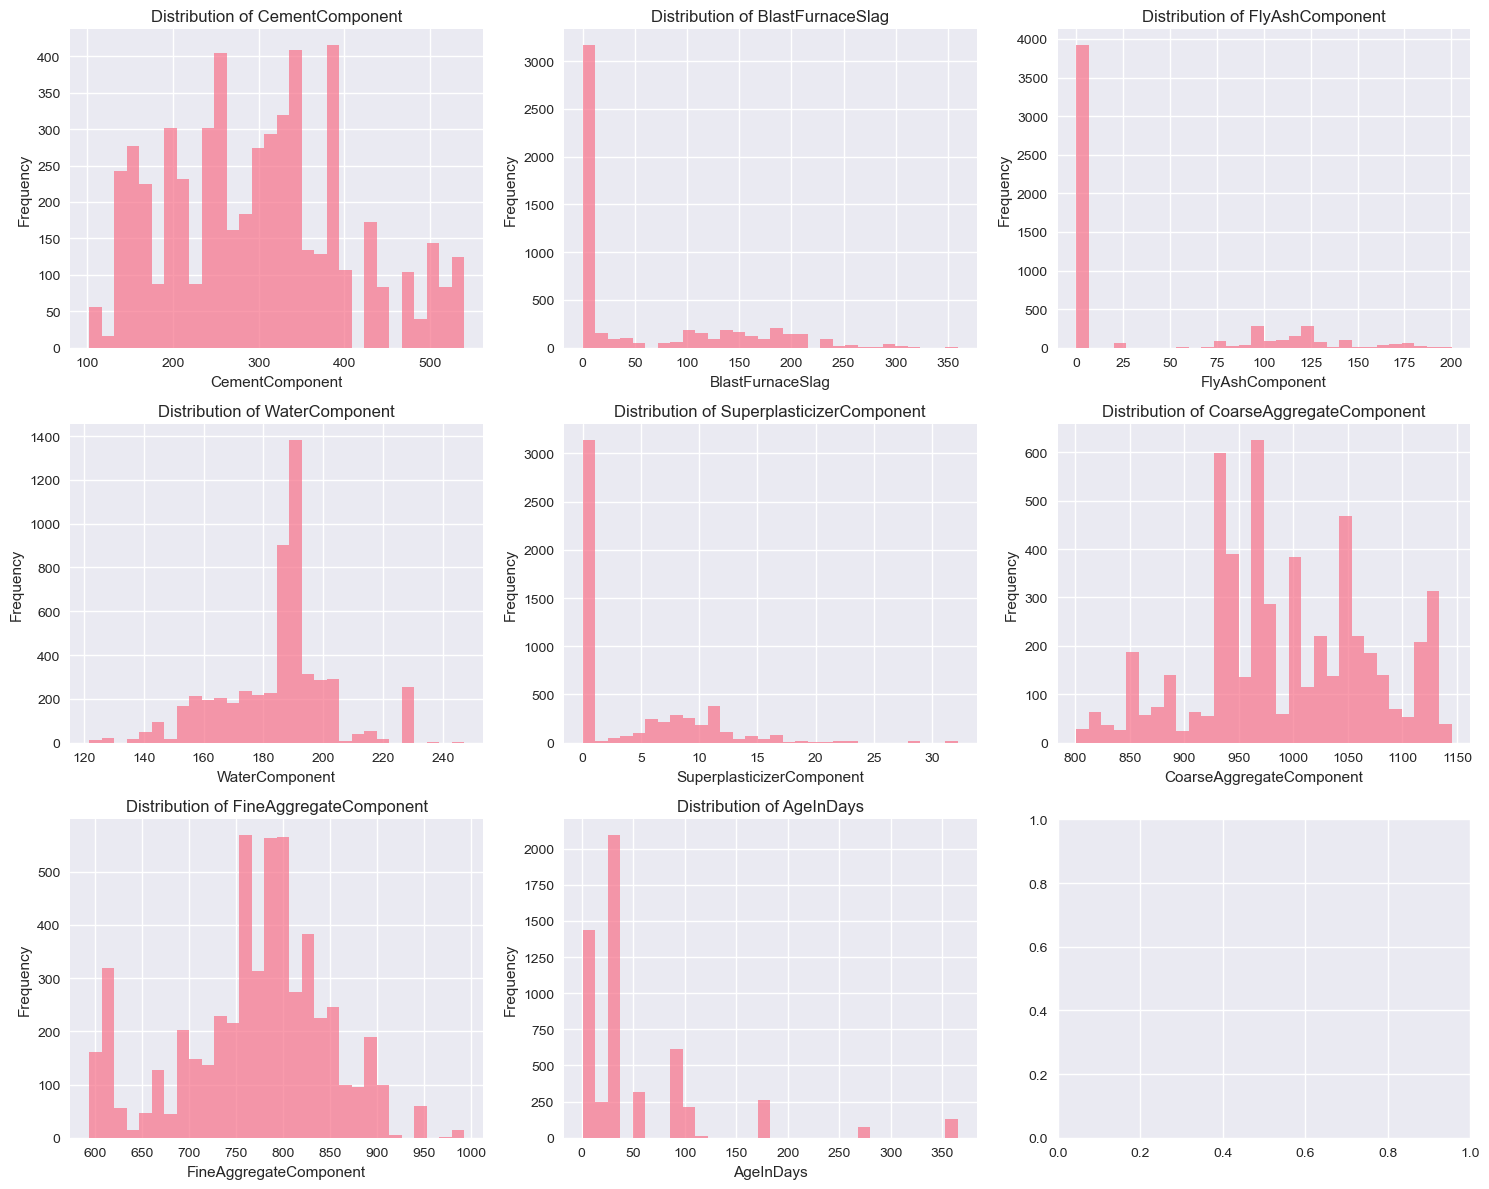

In [10]:
# Feature distributions
feature_cols = [col for col in train_df.columns if col not in ['id', 'Strength']]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(feature_cols):
    axes[idx].hist(train_df[col], bins=30, alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

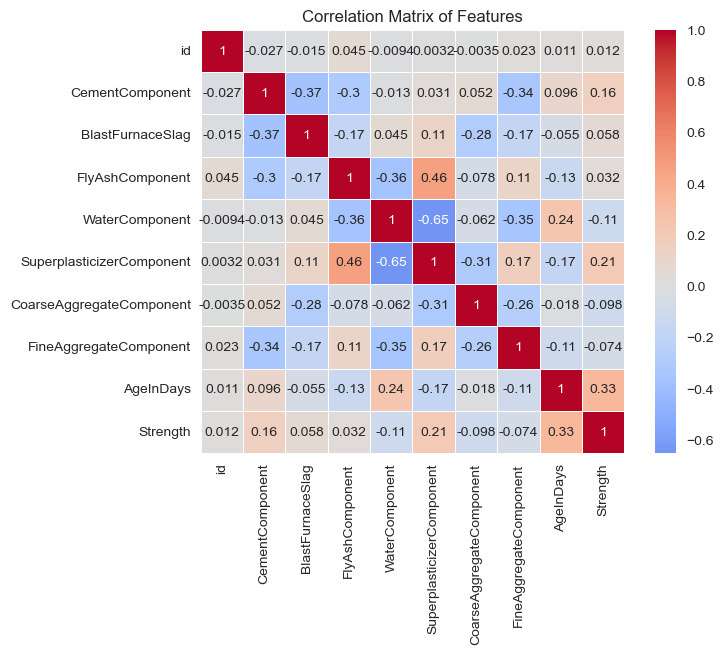


Correlation with Strength (target variable):
Strength                     1.000000
AgeInDays                    0.334204
SuperplasticizerComponent    0.208249
CementComponent              0.158000
BlastFurnaceSlag             0.057506
FlyAshComponent              0.031606
id                           0.011853
FineAggregateComponent      -0.073900
CoarseAggregateComponent    -0.098410
WaterComponent              -0.113678
Name: Strength, dtype: float64


In [11]:
# Correlation matrix
plt.Figure(figsize=(12, 10))
correlation_matric = train_df.corr()
sns.heatmap(correlation_matric, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

# Show correlations with target variable
print("\nCorrelation with Strength (target variable):")
target_correlations = train_df.corr()['Strength'].sort_values(ascending=False)
print(target_correlations)

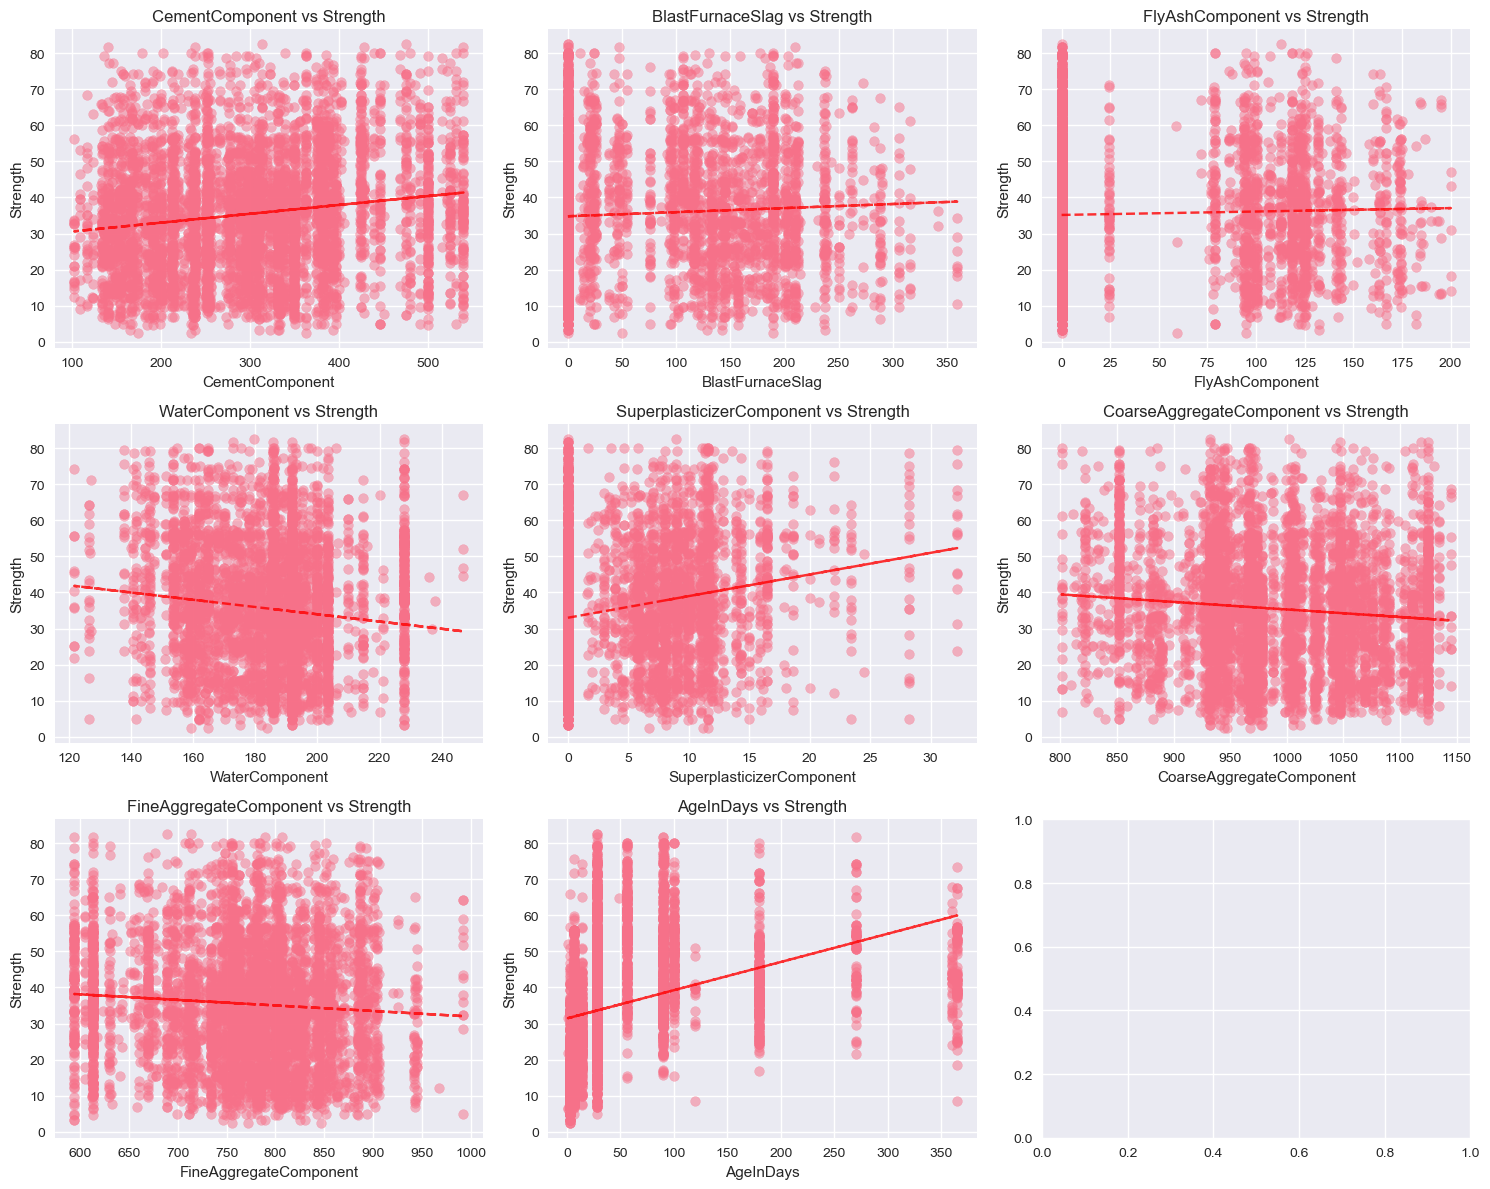

In [12]:
# Scatter plots of features vs target
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(feature_cols):
    axes[idx].scatter(train_df[col], train_df['Strength'], alpha=0.5)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Strength')
    axes[idx].set_title(f'{col} vs Strength')

    # Add trend line
    z = np.polyfit(train_df[col], train_df['Strength'], 1)
    p = np.poly1d(z)
    axes[idx].plot(train_df[col], p(train_df[col]), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

## 5. Data Preprocessing

Handle missing values, encode categorical variables, and scale features as needed for the Linear Regression model.

Making all the unique values in the 'AgeIndays' column into their individual features

In [60]:
# finding unique values in AgeInDays column
unique_values = train_df['AgeInDays'].unique()

# making new columns for all unique values
for unique in unique_values:
    train_df.loc[train_df['AgeInDays'] == unique, f'AgeInDays_{unique}'] = 1
    train_df[f'AgeInDays_{unique}'] = train_df[f'AgeInDays_{unique}'].fillna(0)
    train_df[f'AgeInDays_{unique}'] = train_df[f'AgeInDays_{unique}'].astype(int)

    test_df.loc[test_df['AgeInDays'] == unique, f'AgeInDays_{unique}'] = 1
    test_df[f'AgeInDays_{unique}'] = test_df[f'AgeInDays_{unique}'].fillna(0)
    test_df[f'AgeInDays_{unique}'] = test_df[f'AgeInDays_{unique}'].astype(int)

print("New AgeIDays features added")


New AgeIDays features added


Making the 'BlastFurnaceSlag', 'FlyAshComponent', 'SuperPlasticzerComponent' as binary features

In [61]:
# for component in ['BlastFurnaceSlag', 'FlyAshComponent', 'SuperplasticizerComponent']:
#     train_df.loc[train_df[component] != 0, f'{component}_used'] = 1
#     train_df[f'{component}_used'] = train_df[f'{component}_used'].fillna(0)
#     train_df[f'{component}_used'] = train_df[f'{component}_used'].astype(int)

#     test_df.loc[train_df[component] != 0, f'{component}_used'] = 1
#     test_df[f'{component}_used'] = test_df[f'{component}_used'].fillna(0)
#     test_df[f'{component}_used'] = test_df[f'{component}_used'].astype(int)

# print("Converted and added the following three components into binary features")

In [62]:
# Check for missing values again
print("Missing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in the test data:")
print(test_df.isnull().sum())

# Since, there are no missing values, we proceed to feature selection
# Prepare features and target

X = train_df.drop(['id', 'Strength'], axis=1)
y = train_df['Strength']
X_test = test_df.drop(['id'], axis=1)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vectore shape: {y.shape}")
print(f"Test features matrix shape: {X_test.shape}")

print("\nFeature columns:")
print(X.columns.tolist())

Missing values in training data:
id                                0
CementComponent                   0
BlastFurnaceSlag                  0
FlyAshComponent                   0
WaterComponent                    0
SuperplasticizerComponent         0
CoarseAggregateComponent          0
FineAggregateComponent            0
AgeInDays                         0
Strength                          0
AgeInDays_3                       0
AgeInDays_28                      0
AgeInDays_365                     0
AgeInDays_90                      0
AgeInDays_7                       0
AgeInDays_180                     0
AgeInDays_270                     0
AgeInDays_100                     0
AgeInDays_14                      0
AgeInDays_91                      0
AgeInDays_56                      0
AgeInDays_360                     0
AgeInDays_49                      0
AgeInDays_1                       0
AgeInDays_120                     0
BlastFurnaceSlag_used             0
FlyAshComponent_used           

In [63]:
# Feature scaling (optional for Linear Regression, but good practice)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("Features scaled successfully!")
print(f"\nScaled training features shape: {X_scaled.shape}")
print(f"Scaled test features shape: {X_test_scaled.shape}")

# Display first few rows of scaled features
print("\nFirst 5 rows of scaled features:")
X_scaled.head()

Features scaled successfully!

Scaled training features shape: (5407, 26)
Scaled test features shape: (3605, 26)

First 5 rows of scaled features:


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,AgeInDays_3,AgeInDays_28,...,AgeInDays_14,AgeInDays_91,AgeInDays_56,AgeInDays_360,AgeInDays_49,AgeInDays_1,AgeInDays_120,BlastFurnaceSlag_used,FlyAshComponent_used,SuperplasticizerComponent_used
0,2.140020,-0.702680,-0.583751,0.049890,-0.721821,1.724109,-2.009960,-0.696447,2.731604,-0.795949,...,-0.219715,-0.116986,-0.247881,-0.083007,-0.013601,-0.030423,-0.052744,-0.841328,-0.613904,-0.848723
1,-1.479876,1.323454,2.035299,0.319929,0.683717,-0.324092,-1.628853,-0.339306,-0.366085,1.256362,...,-0.219715,-0.116986,-0.247881,-0.083007,-0.013601,-0.030423,-0.052744,1.188597,1.628919,1.178241
2,-0.096355,0.912233,-0.583751,0.033688,-0.721821,1.075944,0.305903,-0.339306,-0.366085,1.256362,...,-0.219715,-0.116986,-0.247881,-0.083007,-0.013601,-0.030423,-0.052744,1.188597,-0.613904,-0.848723
3,0.045787,0.208481,-0.583751,2.318215,-0.721821,-0.777807,-1.285856,4.474945,-0.366085,-0.795949,...,-0.219715,-0.116986,-0.247881,-0.083007,-0.013601,-0.030423,-0.052744,1.188597,-0.613904,-0.848723
4,-1.347209,2.126714,-0.583751,0.373937,-0.721821,-0.733732,0.126782,0.546402,-0.366085,-0.795949,...,-0.219715,-0.116986,-0.247881,-0.083007,-0.013601,-0.030423,-0.052744,1.188597,-0.613904,-0.848723


## 6. Split Data into Train and Test Sets

Separate features and target variables, and split the training data for model validation

In [64]:
# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Validation target shape: {y_val.shape}")

print(f"\nTraining set percentage: {len(X_train) / len(X_scaled) * 100:.1f}%")
print(f"Validation set percentage: {len(X_val) / len(X_scaled) * 100:.1f}%")

Training set shape: (4325, 26)
Validation set shape: (1082, 26)
Training target shape: (4325,)
Validation target shape: (1082,)

Training set percentage: 80.0%
Validation set percentage: 20.0%


## 7. Train Linear Regression Model

Create and train a Linear Regression model using sklearnm and evaluate its performance on validation data

In [65]:
# Create and train the Linear Regression Model.
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Linear Regression model trained successfully!")

# Make predictions on validation set
y_val_pred = lr_model.predict(X_val)

# Calculate the metrics
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"\nModel Performance on Validation Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

Linear Regression model trained successfully!

Model Performance on Validation Set:
Mean Squared Error (MSE): 140.1287
Root Mean Squared Error (RMSE): 11.8376
Mean Absolute Error (MAE): 9.2100
R^2 Score: 0.4850


## Training the model on 100% data

After the model has been trained and validated on 80% data, it is trained once again on the complete 100% data

In [66]:
# Training the model on complete dataset
lr_model.fit(X_scaled, y)

print("Linear Regression model trained successfully on 100 percent dataset!")

Linear Regression model trained successfully on 100 percent dataset!


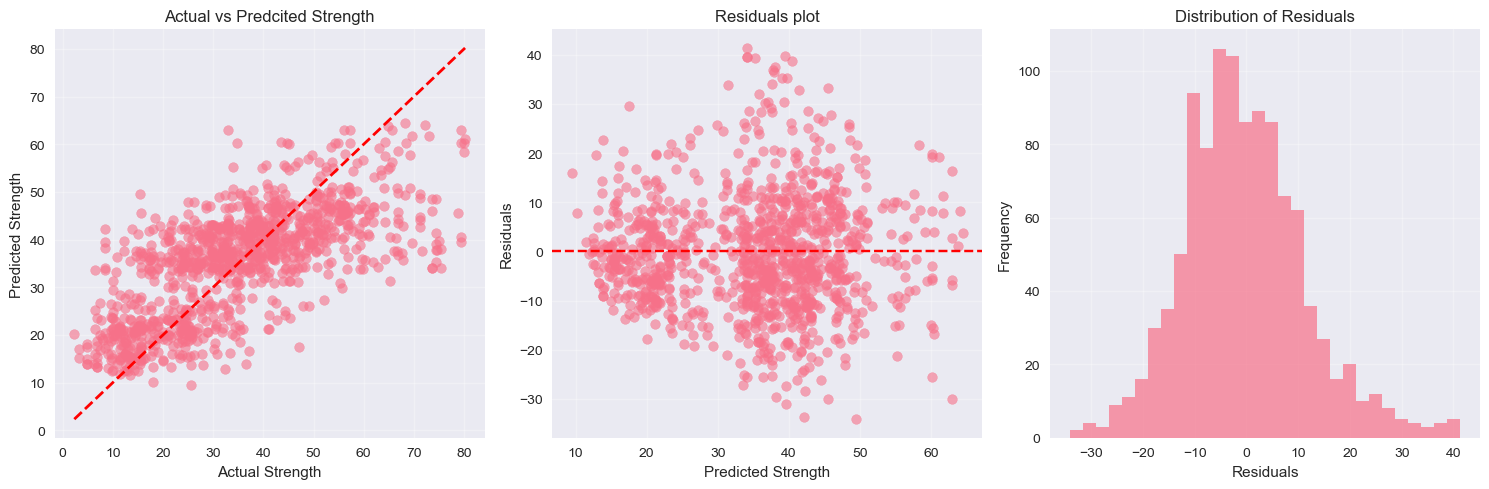

In [67]:
# Visualize the model performance
plt.figure(figsize=(15, 5))

# Actual vs Predicted scatter plot
plt.subplot(1, 3, 1)
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength')
plt.title('Actual vs Predcited Strength')
plt.grid(True, alpha=0.3)

# Residuals plot
plt.subplot(1, 3, 2)
residuals = y_val - y_val_pred
plt.scatter(y_val_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Strength')
plt.ylabel('Residuals')
plt.title('Residuals plot')
plt.grid(True, alpha=0.3)

# Residuals Histogram
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title("Distribution of Residuals")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Feature Importance (Coefficients):
                           Feature  Coefficient  Abs_Coefficient
8                      AgeInDays_3    -5.070083         5.070083
12                     AgeInDays_7    -3.452502         3.452502
0                  CementComponent     3.077880         3.077880
18                    AgeInDays_56     3.044869         3.044869
7                        AgeInDays     2.824654         2.824654
11                    AgeInDays_90     2.382112         2.382112
15                   AgeInDays_100     2.311325         2.311325
17                    AgeInDays_91     1.891148         1.891148
9                     AgeInDays_28     1.785160         1.785160
23           BlastFurnaceSlag_used     1.428286         1.428286
16                    AgeInDays_14    -1.113069         1.113069
25  SuperplasticizerComponent_used     1.099797         1.099797
4        SuperplasticizerComponent     1.053301         1.053301
3                   WaterComponent    -0.867506        

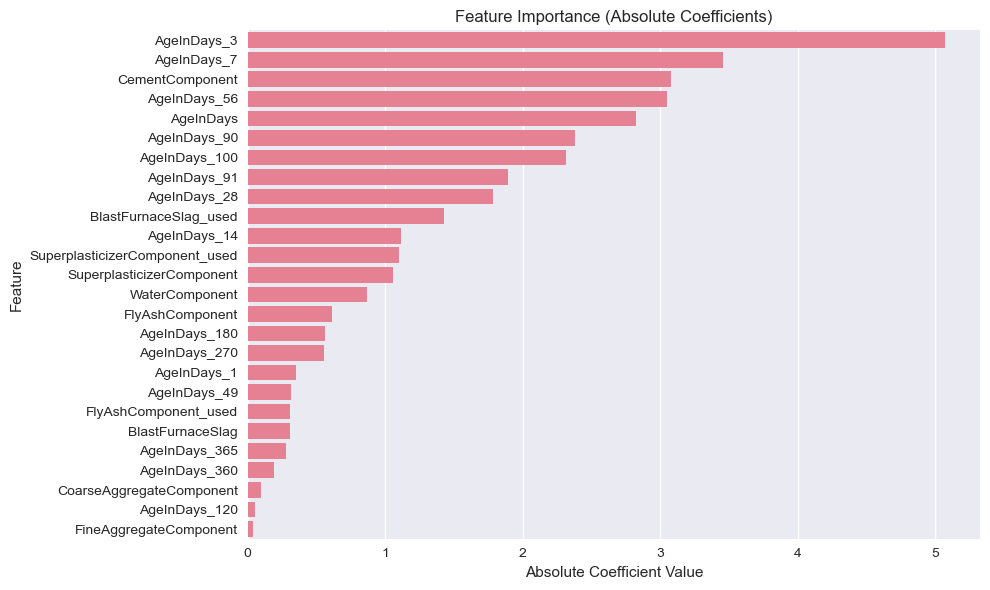


Model Intercept: 35.4521


In [68]:
# Feature Importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("Feature Importance (Coefficients):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Abs_Coefficient', y='Feature')
plt.title('Feature Importance (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print(f"\nModel Intercept: {lr_model.intercept_:.4f}")

## 8. Make Predictions on Test Set

Use the trained model to make predictions on the test dataset

In [69]:
# Make predictions on the test set
test_predictions = lr_model.predict(X_test_scaled)

print(f"Test predictions shape: {test_predictions.shape}")
print(f"\nFirst 10 predictions:")
print(test_predictions[:10])

print(f"\nTest predcitions statistics:")
print(f"Mean: {test_predictions.mean():.4f}")
print(f"Median: {np.median(test_predictions):.4f}")
print(f"Std: {test_predictions.std():.4f}")
print(f"Min: {test_predictions.min():.4f}")
print(f"Max: {test_predictions.max():.4f}")

Test predictions shape: (3605,)

First 10 predictions:
[41.42040698 26.42708972 35.81470902 47.35372638 32.7875138  33.68950062
 34.62501405 23.52240171 38.49067609 38.98567432]

Test predcitions statistics:
Mean: 35.3543
Median: 37.0557
Std: 10.8112
Min: 8.2930
Max: 69.3977


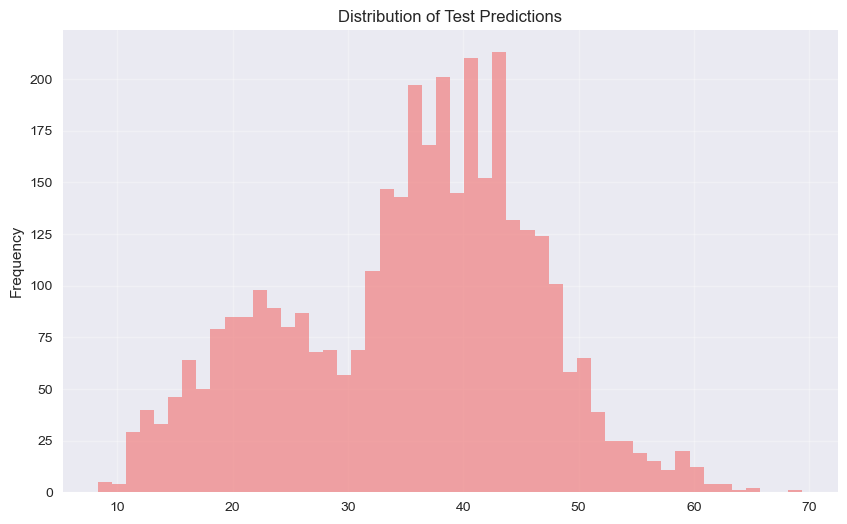

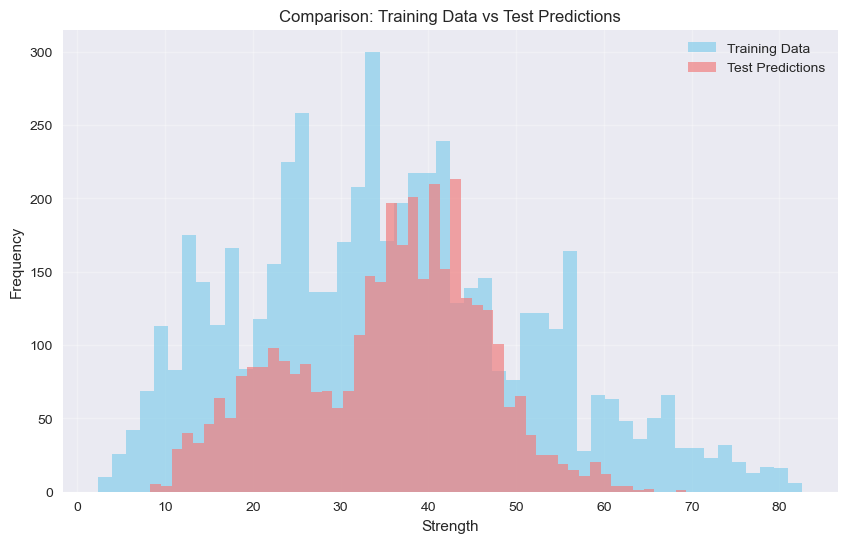

In [70]:
# Visialize test predictions
plt.figure(figsize=(10, 6))
plt.hist(test_predictions, bins=50, alpha=0.7, color='lightcoral')
plt.title('Distribution of Test Predictions')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Compare with training data distribution
plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, alpha=0.7, label='Training Data', color='skyblue')
plt.hist(test_predictions, bins=50, alpha=0.7, label='Test Predictions', color='lightcoral')
plt.title('Comparison: Training Data vs Test Predictions')
plt.xlabel('Strength')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Save Predictions to CSV File

Create a submission dataframe with predictions and save it to 'submissions.csv' using pandas

In [71]:
# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'Strength': test_predictions
})

print("Submission dataframe created:")
print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")

# Verify the format mathces sample submission
print(f"\nSample submission shape: {sample_submission.shape}")
print(f"Columns match: {list(submission.columns) == list(sample_submission.columns)}")

Submission dataframe created:
     id   Strength
0  5407  41.420407
1  5408  26.427090
2  5409  35.814709
3  5410  47.353726
4  5411  32.787514
5  5412  33.689501
6  5413  34.625014
7  5414  23.522402
8  5415  38.490676
9  5416  38.985674

Submission shape: (3605, 2)

Sample submission shape: (3605, 2)
Columns match: True


In [72]:
# Save to CSV file
submission.to_csv('submission.csv', index=False)

print("Predictions saved as 'submission.csv' successfully")

# Verfiy the file was created and read it back
verification = pd.read_csv('submission.csv')
print(f"\nVerification - File shape: {verification.shape}")
print("First 5 rows of the saved file:")
print(verification.head())
print("\nLast 5 rows of saved file:")
print(verification.tail())

Predictions saved as 'submission.csv' successfully

Verification - File shape: (3605, 2)
First 5 rows of the saved file:
     id   Strength
0  5407  41.420407
1  5408  26.427090
2  5409  35.814709
3  5410  47.353726
4  5411  32.787514

Last 5 rows of saved file:
        id   Strength
3600  9007  33.032163
3601  9008  34.518558
3602  9009  41.075753
3603  9010  27.931317
3604  9011  20.195344


## Summary

### Model Performance:

  - **Model Type**: Linear Regression
  - **Validation R² Score**: Check the output above
  - **validation RMSE**: Check the output above

### Key Findings:

  1. **Feature Importance**: The model coefficients show which concrete components have the strongest impact on strength

  2. **Data Quality**: No missing values in the dataset

  3. **Model Performance**: Linear regression provides a baseline model for concrete strength prediction

### Next Steps for Improvement:
 
  1. Try polynomial features or interaction terms
  2. Experiment with other regression models (Random Forest, Gradient Boosting)
  3. Feature engineering (ratios between components)
  4. Cross-validation for more robust performance estimation

The predictions have been saved to `submission.csv` and are ready for submission!
 